In [1]:
#First step is to clean the tweets, we decided not to remove punctuation because emoticons give sentimental value
#Use pickle to load the cleaned dataframe in order to save time afterwards

In [2]:
import re
import pandas as pd
import pickle
import nltk
import matplotlib.pyplot as plt
import numpy as np
import gensim
from string import punctuation
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords


def clean_tweet(tweet):

    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#\w+", "", tweet)
    tweet = re.sub(r"\d", "", tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"_+", "", tweet)
    tweet = re.sub('\$', "", tweet)
    tweet = tweet.lower()

    tokens = tweet.split()
    filtered = [w for w in tokens if not w in stopwords.words('english')]

    tweet = ' '.join(word for word in filtered)

    return tweet.strip()


train_data = r"../twitter_data/train2017.tsv"
test_data  = r"../twitter_data/test2017.tsv"

train_df = pd.read_csv(train_data, sep='\t', names=['unknown', 'id', 'sentiment', 'tweet'])

test_df = pd.read_csv(test_data, sep='\t', names=['unknown', 'id', 'sentiment', 'tweet'])

train_df['tweet'] = train_df['tweet'].apply(clean_tweet)

test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

pickle.dump(test_df, open("test_df.pkl", "wb"))

pickle.dump(train_df, open("train_df.pkl", "wb"))

In [3]:
#Wordcloud with the most common (max 150) words in the (cleaned) dataframe

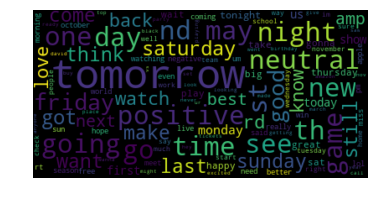

In [4]:
data = pickle.load(open("train_df.pkl", "rb"))

counter = Counter(" ".join(data["tweet"]).split()).most_common(150)

words = []

for word, count in counter:
    words.append(word)

text = ' '.join(word for word in words)

wordcloud = WordCloud(max_font_size=50, max_words=150).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
#Histogram to show how many tweets contains words close to love, hate, and politics

[nltk_data] Downloading package punkt to /home/kostas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


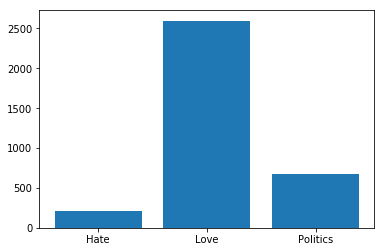

In [6]:
nltk.download('punkt')

train_df = pickle.load(open("train_df.pkl", "rb"))

love_words = ['adorable', 'affection', 'angel', 'caring', 'chocolate', 'compassion', 'dear', 'desire', 'devotion',
                'forever', 'fondness', 'family', 'friendship', 'happy', 'happiness', 'husband', 'hug', 'hugs',
                'husband', 'wife', 'joy', 'kiss', 'love', 'sex', 'relationship', 'passion', 'sweet', 'sweetheart',
                'trust', 'like']

hate_words = ['hate', 'dislike', 'disgust', 'pain', 'antipathy', 'hatred', 'antagonism', 'repulsion', 'hostility',
                'horror', 'war', 'abandon', 'terrible', 'awful', 'offensive', 'hideous', 'creepy', 'chaotic',
                'horrifying']

political_words = ['trump', 'obama', 'political', 'party', 'vote', 'voting', 'conservative', 'debate', 'campaign',
                    'contribution', 'election', 'government', 'economy', 'poll', 'unemployment', 'rate']

rows, columns = train_df.shape

df = pd.DataFrame(index=np.arange(0, rows), columns=['id', 'subject'])

for index in np.arange(0, rows):

    tweet = train_df['tweet'][index]

    words = word_tokenize(tweet)
    df['id'][index] = train_df['id'][index]

    found_sub = False
    for word in words:
        if word in love_words:
            df['subject'][index] = 'Love'
            found_sub = True
        if word in hate_words:
            df['subject'][index] = 'Hate'
            found_sub = True
        if word in political_words:
            df['subject'][index] = 'Politics'
            found_sub = True

    if found_sub == False:
        df['subject'][index] = 'N/D'


df = df.loc[df['subject'] != 'N/D']

counter = Counter(df['subject'])
subject = counter.keys()
subject_counts = counter.values()

indexes = np.arange(len(subject))
plt.bar(indexes, subject_counts)
plt.xticks(indexes, subject)
plt.show()

In [7]:
#Here we use the dictionaries provided to compute if a word contained in a tweet is a negative word
#based on the sentiment value
#Wordcloud with the most common (200) negative words

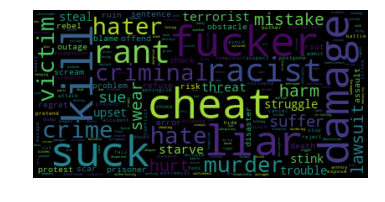

In [8]:
data = pickle.load(open("train_df.pkl", "rb"))

sentences = ' '.join(sent for sent in data['tweet'])

word_list = word_tokenize(sentences)

dictionary = pd.read_csv(r'../lexica/affin/affin.txt', sep='\t', names=['word', 'sentiment'])

dictionary = dictionary.sort_values(by=['sentiment'], ascending=True)

negative = dictionary.loc[dictionary['sentiment'] <= -1]

negative_words = []

for word in negative['word']:
    if word in word_list:
        negative_words.append(word)

text_neg = ' '.join(word for word in negative_words)

wordcloud_neg = WordCloud(max_font_size=50, max_words=200).generate(text_neg)

plt.figure()
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
#Wordcloud with the most common (200) positive words

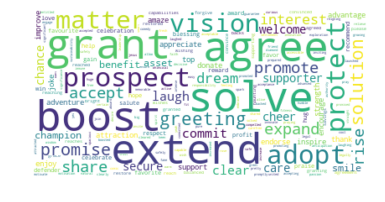

In [10]:
data = pickle.load(open("train_df.pkl", "rb"))

sentences = ' '.join(sent for sent in data['tweet'])

word_list = word_tokenize(sentences)

dictionary = pd.read_csv(r'../lexica/affin/affin.txt', sep='\t', names=['word', 'sentiment'])

dictionary = dictionary.sort_values(by=['sentiment'], ascending=True)

positive = dictionary.loc[dictionary['sentiment'] >= 1]

positive_words = []

for word in positive['word']:
    if word in word_list:
        positive_words.append(word)

text_pos = ' '.join(word for word in positive_words)

wordcloud_pos = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text_pos)

plt.figure()
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
#Bag of words vectorizer and results using svm and knn classifiers

In [12]:
train_df = pickle.load(open("train_df.pkl", "rb"))

test_df = pickle.load(open("test_df.pkl", "rb"))

bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=2000, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(train_df['tweet'])

bow_xtest = bow_vectorizer.transform(test_df['tweet'])

ytrain = []

for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        ytrain.append(0)
    elif sentiment == 'neutral':
        ytrain.append(1)
    else:
        ytrain.append(2)

svc = svm.SVC(kernel='linear', C=1, probability=True)

svc = svc.fit(bow_xtrain, ytrain)

file_contents = [line.strip('\n') for line in open(r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt')]

ytrue = []

for line in file_contents:
    sentiment = line.split('\t')
    if sentiment[1] == 'positive':
        ytrue.append(0)
    elif sentiment[1] == 'neutral':
        ytrue.append(1)
    else:
        ytrue.append(2)

prediction = svc.predict(bow_xtest)

bow_svc = f1_score(ytrue, prediction, average='macro')
print('BOW_SVC : ' + str(bow_svc))

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(bow_xtrain, ytrain)

prediction = knn.predict(bow_xtest)

bow_knn = f1_score(ytrue, prediction, average='macro')
print('BOW_KNN : ' + str(bow_knn))

BOW_SVC : 0.49349578303003455
BOW_KNN : 0.39274169326159325


In [13]:
#Tfidf vectorizer and results using svm and knn classifiers

In [14]:
train_df = pickle.load(open("train_df.pkl", "rb"))

test_df = pickle.load(open("test_df.pkl", "rb"))

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=2000, stop_words='english')

tfidf_xtrain = tfidf_vectorizer.fit_transform(train_df['tweet'])

tfidf_xtest = tfidf_vectorizer.transform(test_df['tweet'])

ytrain = []

for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        ytrain.append(0)
    elif sentiment == 'neutral':
        ytrain.append(1)
    else:
        ytrain.append(2)

svc = svm.SVC(kernel='linear', C=1, probability=True)

svc = svc.fit(tfidf_xtrain, ytrain)

file_contents = [line.strip('\n') for line in open(r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt')]

ytrue = []

for line in file_contents:
    sentiment = line.split('\t')
    if sentiment[1] == 'positive':
        ytrue.append(0)
    elif sentiment[1] == 'neutral':
        ytrue.append(1)
    else:
        ytrue.append(2)

prediction = svc.predict(tfidf_xtest)

tfidf_svc = f1_score(ytrue, prediction, average='macro')
print('TFIDF_SVC : ' + str(tfidf_svc))

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(tfidf_xtrain, ytrain)

prediction = knn.predict(tfidf_xtest)
tfidf_knn = f1_score(ytrue, prediction, average='macro')
print('TFIDF_KNN : ' + str(tfidf_knn))

TFIDF_SVC : 0.4894980562450845
TFIDF_KNN : 0.3618693109762326


In [15]:
def update_affin(train_df, test_df, vectors):

    affin = open(r"../lexica/affin/affin.txt", 'r')

    tmp_lines = affin.readlines()

    lines = []

    min_val = -4
    max_val = 4

    vectors = np.hstack((vectors, np.zeros((vectors.shape[0], 1), dtype=vectors.dtype)))

    for line in tmp_lines:
        tokens = line.split('\t')
        num = 2.0 * ((float(tokens[1]) - min_val) / (max_val - min_val)) - 1.0
        newline = tokens[0] + '\t' + str(num)
        lines.append(newline)

    current = 0
    for tweet in train_df['tweet']:
        sum = 0.0
        count = 0
        for word in tweet.split():
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    for tweet in test_df['tweet']:
        sum = 0.0
        count = 0
        for word in word_tokenize(tweet):
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    return vectors


def update_valence(train_df, test_df, vectors):

    valence = open(r"../lexica/emotweet/valence_tweet.txt")

    vectors = np.hstack((vectors, np.zeros((vectors.shape[0], 1), dtype=vectors.dtype)))

    lines = valence.readlines()

    current = 0
    for tweet in train_df['tweet']:
        sum = 0.0
        count = 0
        for word in word_tokenize(tweet):
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    for tweet in test_df['tweet']:
        sum = 0.0
        count = 0
        for word in word_tokenize(tweet):
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    return vectors


def update_generic(train_df, test_df, vectors):

    generic = open(r"../lexica/generic/generic.txt", 'r')

    vectors = np.hstack((vectors, np.zeros((vectors.shape[0], 1), dtype=vectors.dtype)))

    lines = generic.readlines()

    current = 0

    for tweet in train_df['tweet']:
        sum = 0.0
        count = 0
        for word in word_tokenize(tweet):
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    for tweet in test_df['tweet']:
        sum = 0.0
        count = 0
        for word in word_tokenize(tweet):
            for line in lines:
                tokens = line.split('\t')
                if word == tokens[0]:
                    sum += float(tokens[1])
                    count += 1
                    break
        if count != 0:
            vectors[current][vectors.shape[1] - 1] = sum / count
        else:
            vectors[current][vectors.shape[1] - 1] = np.random.random_sample()

        current += 1

    return vectors

train_df = pickle.load(open("train_df.pkl", "rb"))

test_df = pickle.load(open("test_df.pkl", "rb"))

all_tweets = []

for tweet in train_df['tweet']:
    all_tweets.append(tweet)

for tweet in test_df['tweet']:
    all_tweets.append(tweet)

tokenized_tweets = []

for tweet in all_tweets:
    tokenized_tweets.append(word_tokenize(tweet))

model_size = 300

model_w2v = gensim.models.Word2Vec(tokenized_tweets, size=model_size, window=5, min_count=2, sg=1, hs=0, negative=10,
                                    workers=4, seed=34)

model_w2v.train(tokenized_tweets, total_examples=len(tokenized_tweets), epochs=20)

pickle.dump(model_w2v, open("model_w2v_plot.pkl", "wb"))

vectors = np.zeros((len(tokenized_tweets), model_size))

tweet_num = 0
for tweet in tokenized_tweets[:len(train_df['tweet'])]:
    i = 0
    temp_vec = vectors[tweet_num]
    for word in tweet:
        if word not in model_w2v.wv.vocab:
            rand_vec = 2 * np.random.random_sample(model_size) - 1.0
            temp_vec = np.add(rand_vec, temp_vec)
        else:
            temp_vec = np.add(model_w2v[word], temp_vec)
        i += 1

    if i != 0:
        vectors[tweet_num] = np.divide(temp_vec, i)
    else:
        vectors[tweet_num] = 2 * np.random.random_sample(model_size) - 1.0

    tweet_num += 1

for tweet in tokenized_tweets[len(train_df['tweet']):]:
    i = 0
    temp_vec = vectors[tweet_num]
    for word in tweet:
        if word not in model_w2v.wv.vocab:
            rand_vec = 2 * np.random.random_sample(model_size) - 1.0
            temp_vec = np.add(rand_vec, temp_vec)
        else:
            temp_vec = np.add(model_w2v[word], temp_vec)
        i += 1

    if i != 0:
        vectors[tweet_num] = np.divide(temp_vec, i)
    else:
        vectors[tweet_num] = 2 * np.random.random_sample(model_size) - 1.0

    tweet_num += 1

w2v_test_train = vectors

w2v_test_train = update_affin(train_df, test_df, w2v_test_train)

w2v_test_train = update_generic(train_df, test_df, w2v_test_train)

w2v_test_train = update_valence(train_df, test_df, w2v_test_train)

pickle.dump(w2v_test_train, open("w2v_updated.pkl", "wb"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:187: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:205: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [16]:
train_df = pickle.load(open("train_df.pkl", "rb"))

test_df = pickle.load(open("test_df.pkl", "rb"))

w2v_test_train = pickle.load(open("w2v_updated.pkl", "rb"))

w2v_xtrain = w2v_test_train[:len(train_df['tweet'])]
w2v_xtest = w2v_test_train[len(train_df['tweet']):]

ytrain = []

for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        ytrain.append(0)
    elif sentiment == 'neutral':
        ytrain.append(1)
    else:
        ytrain.append(2)

svc = svm.SVC(kernel='linear', C=1, probability=True)

svc = svc.fit(w2v_xtrain, ytrain)

file_contents = [line.strip('\n') for line in open(r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt')]

ytrue = []

for line in file_contents:
    sentiment = line.split('\t')
    if sentiment[1] == 'positive':
        ytrue.append(0)
    elif sentiment[1] == 'neutral':
        ytrue.append(1)
    else:
        ytrue.append(2)

prediction = svc.predict(w2v_xtest)

w2v_svc = f1_score(ytrue, prediction, average='macro')
print('W2V_SVC : ' + str(w2v_svc))

knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(w2v_xtrain, ytrain)

prediction = knn.predict(w2v_xtest)

w2v_knn = f1_score(ytrue, prediction, average='macro')
print('W2V_KNN : ' + str(w2v_knn))

W2V_SVC : 0.5763293024484324
W2V_KNN : 0.4420654812027483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


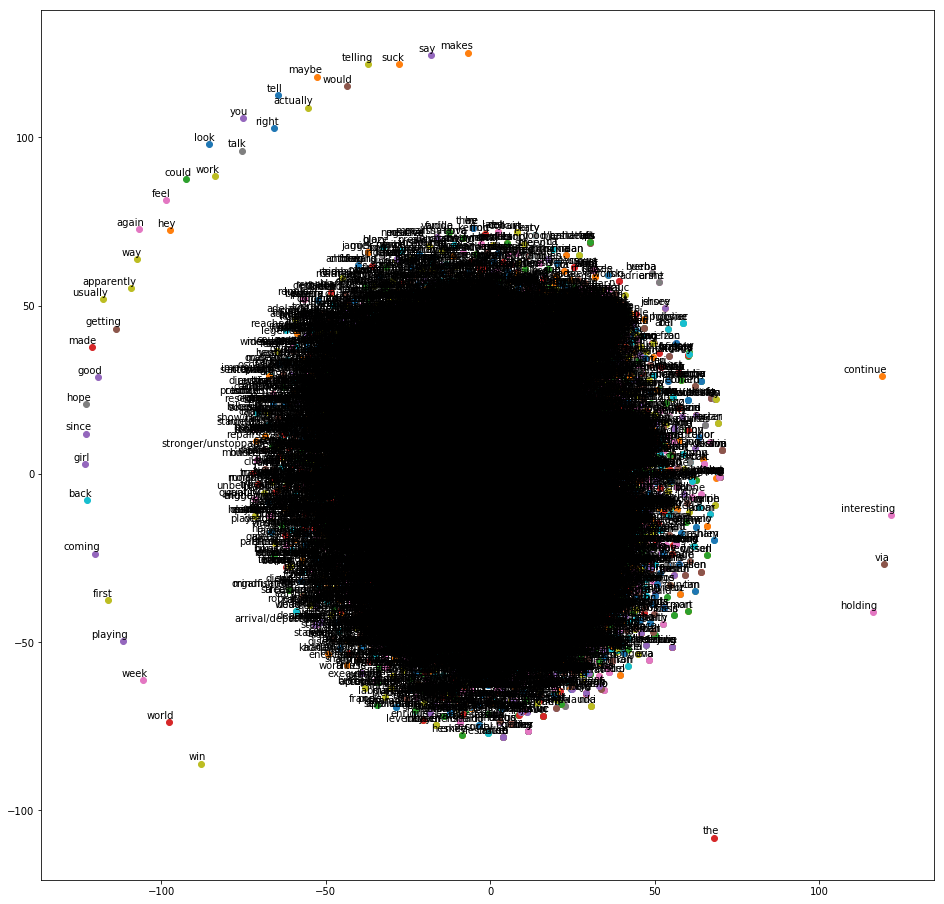

In [17]:
def tsne_plot(model):

    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))

    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.show()
    

model = pickle.load(open("model_w2v_plot.pkl", "rb"))

tsne_plot(model)

In [18]:
train_df = pickle.load(open("train_df.pkl", "rb"))

test_df = pickle.load(open("test_df.pkl", "rb"))

w2v_train_test = pickle.load(open("w2v_updated.pkl", "rb"))

w2v_xtrain = w2v_train_test[:len(train_df['tweet'])]

w2v_xtest = w2v_train_test[len(train_df['tweet']):]

pos_neg_ytrain = []
pos_neg_xtrain = []
pos_neg_xtest = []

count = 0

for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        pos_neg_xtrain.append(w2v_xtrain[count])
        pos_neg_ytrain.append(0)
    elif sentiment == 'negative':
        pos_neg_xtrain.append(w2v_xtrain[count])
        pos_neg_ytrain.append(2)

    count += 1

pos_neu_ytrain = []
pos_neu_xtrain = []

count = 0

for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        pos_neu_xtrain.append(w2v_xtrain[count])
        pos_neu_ytrain.append(0)
    elif sentiment == 'neutral':
        pos_neu_xtrain.append(w2v_xtrain[count])
        pos_neu_ytrain.append(1)

    count += 1

neg_neu_ytrain = []
neg_neu_xtrain = []

count = 0

for sentiment in train_df['sentiment']:
    if sentiment == 'neutral':
        neg_neu_xtrain.append(w2v_xtrain[count])
        neg_neu_ytrain.append(1)
    elif sentiment == 'negative':
        neg_neu_xtrain.append(w2v_xtrain[count])
        neg_neu_ytrain.append(2)

    count += 1

pos_neg_knn = KNeighborsClassifier(n_neighbors=4)

pos_neg_knn.fit(pos_neg_xtrain, pos_neg_ytrain)

pos_neg_pred_train = pos_neg_knn.predict_proba(w2v_xtrain)

pos_neg_pred_test = pos_neg_knn.predict_proba(w2v_xtest)

pos_neu_knn = KNeighborsClassifier(n_neighbors=4)

pos_neu_knn.fit(pos_neu_xtrain, pos_neu_ytrain)

pos_neu_pred_train = pos_neu_knn.predict_proba(w2v_xtrain)

pos_neu_pred_test = pos_neg_knn.predict_proba(w2v_xtest)

neg_neu_knn = KNeighborsClassifier(n_neighbors=4)

neg_neu_knn.fit(neg_neu_xtrain, neg_neu_ytrain)

neg_neu_pred_train = pos_neu_knn.predict_proba(w2v_xtrain)

neg_neu_pred_test = pos_neu_knn.predict_proba(w2v_xtest)

xtrain = []
ytrain = []
xtest = []

count = 0
for sentiment in train_df['sentiment']:
    if sentiment == 'positive':
        ytrain.append(0)
    elif sentiment == 'neutral':
        ytrain.append(1)
    elif sentiment == 'negative':
        ytrain.append(2)

    xtrain.append([pos_neg_pred_train[count][0], pos_neg_pred_train[count][1], pos_neu_pred_train[count][0],
                    pos_neu_pred_train[count][1], neg_neu_pred_train[count][0], neg_neu_pred_train[count][1]])
    count += 1

count = 0

for tweet in test_df['tweet']:
    xtest.append([pos_neg_pred_test[count][0], pos_neg_pred_test[count][1], pos_neu_pred_test[count][0],
                    pos_neu_pred_test[count][1], neg_neu_pred_test[count][0], neg_neu_pred_test[count][1]])
    count += 1

knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(xtrain, ytrain)

prediction = knn.predict(xtest)

file_contents = [line.strip('\n') for line in open(r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt')]

ytrue = []

for line in file_contents:
    sentiment = line.split('\t')
    if sentiment[1] == 'positive':
        ytrue.append(0)
    elif sentiment[1] == 'neutral':
        ytrue.append(1)
    else:
        ytrue.append(2)

w2v_round_robin = f1_score(ytrue, prediction, average='macro')
print('W2V_ROUND_ROBIN : ' + str(w2v_round_robin))

W2V_ROUND_ROBIN : 0.45215086193349957


In [19]:
#Final results, press play to show them up

In [20]:
data = {}

data['BOW'] = [bow_svc, bow_knn, '-']
data['TFIDF'] = [tfidf_svc, tfidf_knn, '-']
data['WE'] = [w2v_svc, w2v_knn, w2v_round_robin]

df = pd.DataFrame(data=data, index=['SVM', 'KNN', 'RR'])
df

,BOW,TFIDF,WE
SVM,0.493496,0.489498,0.576329
KNN,0.392742,0.361869,0.442065
RR,-,-,0.452151
